# Hex fill Notebook

Notebook with algorithm to fill missing hexagons created in lower resolutions where there are no nodes

## Import modules

In [69]:
import os
import sys

import numpy as np
import pandas as pd
import geopandas as gpd
import math
import shapely
import h3

import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Donwload municipality polygons

In [70]:
df = pd.read_json("../scripts/Metropolis_CVE.json")
mpos_folder = 'mpos_2020'
hex_folder = 'hex_bins_index_2020'
mun_gdf = gpd.GeoDataFrame()
ageb_gdf = gpd.GeoDataFrame()
hex_gdf = gpd.GeoDataFrame()

In [71]:
#Download agebs, hexgrid and municipality figures
for c in df.columns.unique():
    if c == 'Guadalajara':
        mun_gdf = gpd.GeoDataFrame()
        hex_gdf = gpd.GeoDataFrame()
        ageb_gdf = gpd.GeoDataFrame()
        for i in range(len(df.loc["mpos", c])):
            # Extracts specific municipality code
            m = df.loc["mpos", c][i]
            # Downloads municipality polygon according to code
            query = f"SELECT * FROM marco.{mpos_folder} WHERE \"CVEGEO\" LIKE \'{m}\'"
            mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
            query = f"SELECT * FROM hexgrid.hexgrid_10 WHERE \"CVEGEO\" LIKE \'{m}\'"
            hex_gdf = hex_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
            query = f"SELECT * FROM marco.ageb_2020 WHERE \"cve_geo_ageb\" LIKE \'{m}%%\'"
            ageb_gdf = ageb_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))

In [72]:
#Define projections
mun_gdf = mun_gdf.set_crs("EPSG:4326")
ageb_gdf = ageb_gdf.set_crs("EPSG:4326")
hex_gdf = hex_gdf.set_crs("EPSG:4326")

## Donwload nodes and edges

In [73]:
#Creates wkt for query
gdf_tmp = mun_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]
aup.log("Created wkt based on dissolved polygon")

In [74]:
#Download nodes with distance to denue data
query = f"SELECT * FROM osmnx.edges WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
edges = aup.gdf_from_query(query, geometry_col='geometry')
aup.log(f"Downloaded {len(edges)} edges from database for {c}")
edges = edges.to_crs("EPSG:4326")
query = f"SELECT * FROM osmnx.nodes WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
nodes = aup.gdf_from_query(query, geometry_col='geometry')
aup.log(f"Downloaded {len(edges)} edges from database for {c}")
nodes = nodes.to_crs("EPSG:4326")


## Hexagon analysis

In [75]:
#PIP (Point in Polygon). Overlays nodes with hexes to find hexes that have nodes in them and those that do not
pip = gpd.overlay(hex_gdf, nodes, how='intersection', keep_geom_type=False)
pip = pip.set_index('hex_id_10')
hex_gdf = hex_gdf.set_index('hex_id_10')
#simplify and keep only relevant columns
pip_idx = pip[['CVEGEO']]
hex_geom = hex_gdf[['geometry']]
#Merge with indicator. Right only means that the hexagon does NOT have any node (first filter)
hex_node = pip_idx.merge(hex_geom, left_index=True, right_index=True, how='outer', indicator=True)
R2 = hex_node[hex_node['_merge']=='right_only']
#(simplify) and plot
R3 = gpd.GeoDataFrame(R2, geometry = 'geometry')
R3 = R3[['geometry']]
R3.reset_index(inplace = True)
#R3.plot()


In [76]:
#LIP (Line in Polygon). Overlays edges with hexes already filtered by nodes
#  to find hexes that have edges in them and those that do not. In this case
#We want to keep those that do have roads.
lip = gpd.overlay(R3, edges, how='intersection', keep_geom_type=False)
lip = lip.set_index('hex_id_10')
R3 = R3.set_index('hex_id_10')
lip_idx = lip[['osmid']]
R3_geom = R3[['geometry']]
#Merge with indicator. Both means that the hex has a road.
hex_edge = lip_idx.merge(R3_geom, left_index=True, right_index=True, how='outer', indicator=True)
hex_edge
R4 = hex_edge[hex_edge['_merge']=='both']
#Simplify and Plot
R5 = gpd.GeoDataFrame(R4, geometry = 'geometry')
R5 = R5[['geometry']]
R5.reset_index(inplace = True)


In [77]:
#AIP (AGEB in Polygon). Overlays agebs with hexes already filtered by nodes and edges
#  to find hexes that have agebs in them and those that do not. In this case
#We want to keep those that are within an ageb.
aip = gpd.overlay(R5, ageb_gdf, how='intersection', keep_geom_type=False)
aip = aip.set_index('hex_id_10')
R5 = R5.set_index('hex_id_10')
aip_idx = aip[['cve_ageb']]
R5_geom = R5[['geometry']]
#Merge with indicator. Both means that the hex has intersects with an ageb.
hex_ageb = aip_idx.merge(R5_geom, left_index=True, right_index=True, how='outer', indicator=True)
R6 = hex_ageb[hex_ageb['_merge']=='both']
#Simplify and Plot
missing_hex = gpd.GeoDataFrame(R6, geometry = 'geometry')
missing_hex = missing_hex[['geometry']]
missing_hex.reset_index(inplace = True)


<AxesSubplot:>

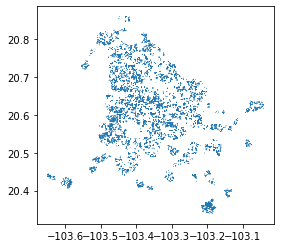

In [78]:
missing_hex.plot()

In [79]:
missing_hex = missing_hex.drop_duplicates(subset=['hex_id_10'])

In [80]:
missing_hex

,hex_id_10,geometry
0,8a498c864a07fff,"POLYGON ((-103.33365 20.77181, -103.33300 20.7..."
16,8a498c864a0ffff,"POLYGON ((-103.33526 20.77390, -103.33518 20.7..."
32,8a498c864a1ffff,"POLYGON ((-103.33251 20.77417, -103.33323 20.7..."
36,8a498c864a37fff,"POLYGON ((-103.33220 20.77120, -103.33228 20.7..."
40,8a498c864b1ffff,"POLYGON ((-103.33285 20.77076, -103.33358 20.7..."
...,...,...
63458,8a49abc9eba7fff,"POLYGON ((-103.60951 20.41938, -103.60958 20.4..."
63462,8a49abc9ecc7fff,"POLYGON ((-103.59636 20.41954, -103.59644 20.4..."
63466,8a49abc9ecd7fff,"POLYGON ((-103.59563 20.41924, -103.59499 20.4..."
63470,8a49abc9ed0ffff,"POLYGON ((-103.59790 20.41452, -103.59863 20.4..."


## Fill missing hexagons

In [81]:
## Start part 2, fill missing hexes with average value of neighbours
missing_hex[['v']] = np.nan
missing_hex


/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,hex_id_10,geometry,v
0,8a498c864a07fff,"POLYGON ((-103.33365 20.77181, -103.33300 20.7...",NaN
16,8a498c864a0ffff,"POLYGON ((-103.33526 20.77390, -103.33518 20.7...",NaN
32,8a498c864a1ffff,"POLYGON ((-103.33251 20.77417, -103.33323 20.7...",NaN
36,8a498c864a37fff,"POLYGON ((-103.33220 20.77120, -103.33228 20.7...",NaN
40,8a498c864b1ffff,"POLYGON ((-103.33285 20.77076, -103.33358 20.7...",NaN
...,...,...,...
63458,8a49abc9eba7fff,"POLYGON ((-103.60951 20.41938, -103.60958 20.4...",NaN
63462,8a49abc9ecc7fff,"POLYGON ((-103.59636 20.41954, -103.59644 20.4...",NaN
63466,8a49abc9ecd7fff,"POLYGON ((-103.59563 20.41924, -103.59499 20.4...",NaN
63470,8a49abc9ed0ffff,"POLYGON ((-103.59790 20.41452, -103.59863 20.4...",NaN


In [82]:
########This should be replaced with the hexes with distance information
######## 'v' = distance
## Optional, I am missing the real values
hexval = hex_node[hex_node['_merge']=='both']
hexval = gpd.GeoDataFrame(hexval, geometry = 'geometry')
hexval.reset_index(inplace=True)
rand = pd.DataFrame(np.random.randint(1,100,size=(195461, 1)), columns=list('v'))
hexval= hexval.merge(rand, left_index=True, right_index=True)
hexval.reset_index(inplace=True)
hexval = hexval.drop_duplicates(subset=['hex_id_10'])
hexval = hexval[['hex_id_10', 'geometry', 'v']]

In [83]:
urb_hex = gpd.GeoDataFrame()

In [84]:
missing_hex.reset_index(inplace = True)
hexval.reset_index(inplace = True)
urb_hex = hexval.append(missing_hex)
urb_hex = urb_hex.set_index('hex_id_10')
missing_hex = missing_hex.set_index('hex_id_10')
hexval = hexval.set_index('hex_id_10')
urb_hex

,index,geometry,v
hex_id_10,,,
8a498c800d87fff,0,"POLYGON ((-103.13840 20.74916, -103.13848 20.7...",2.0
8a498c804417fff,1,"POLYGON ((-103.13906 20.73524, -103.13841 20.7...",12.0
8a498c8044cffff,2,"POLYGON ((-103.14031 20.74074, -103.14104 20.7...",1.0
8a498c8044e7fff,3,"POLYGON ((-103.14066 20.73733, -103.14001 20.7...",64.0
8a498c8044f7fff,4,"POLYGON ((-103.13871 20.73864, -103.13944 20.7...",99.0
...,...,...,...
8a49abc9eba7fff,63458,"POLYGON ((-103.60951 20.41938, -103.60958 20.4...",NaN
8a49abc9ecc7fff,63462,"POLYGON ((-103.59636 20.41954, -103.59644 20.4...",NaN
8a49abc9ecd7fff,63466,"POLYGON ((-103.59563 20.41924, -103.59499 20.4...",NaN


In [85]:
## Start looping
count = 0
iter = 1
urb_hex['v'+ str(count)] = urb_hex['v'].copy()
while urb_hex['v'+str(count)].isna().sum() > 0:
    if count< 5:
        missing = urb_hex[urb_hex['v'+str(count)].isna()]
        urb_hex['v'+ str(iter)] = urb_hex['v'+str(count)].copy()
        for idx,row in missing.iterrows():
            ###Cell 1
            near = pd.DataFrame(h3.k_ring(idx,1))
            near['hex_id_10'] = h3.k_ring(idx,1)
            near['a'] = np.nan
            near= near.set_index('hex_id_10')
            ###Cell 2
            neighbors = near.merge(urb_hex, left_index=True, right_index=True, how='left')
            #Cell 3
            average = neighbors['v'+str(count)].mean()
            urb_hex.at[idx, 'v'+str(iter)] = average
        count = count + 1
        iter = iter + 1
    if count>= 10:
        urb_hex['v'+str(count)] = 1
fill_hex = urb_hex[['geometry']]
fill_hex['v'] = urb_hex['v'+ str(count)].copy()

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [86]:
urb_hex['v'+str(count)].isna().sum()

0

In [90]:
fill_hex.reset_index(inplace = True)
fill_hex

,hex_id_10,geometry,v
0,8a498c800d87fff,"POLYGON ((-103.13840 20.74916, -103.13848 20.7...",2.000000
1,8a498c804417fff,"POLYGON ((-103.13906 20.73524, -103.13841 20.7...",12.000000
2,8a498c8044cffff,"POLYGON ((-103.14031 20.74074, -103.14104 20.7...",1.000000
3,8a498c8044e7fff,"POLYGON ((-103.14066 20.73733, -103.14001 20.7...",64.000000
4,8a498c8044f7fff,"POLYGON ((-103.13871 20.73864, -103.13944 20.7...",99.000000
...,...,...,...
56014,8a49abc9eba7fff,"POLYGON ((-103.60951 20.41938, -103.60958 20.4...",85.500000
56015,8a49abc9ecc7fff,"POLYGON ((-103.59636 20.41954, -103.59644 20.4...",56.333333
56016,8a49abc9ecd7fff,"POLYGON ((-103.59563 20.41924, -103.59499 20.4...",33.666667
56017,8a49abc9ed0ffff,"POLYGON ((-103.59790 20.41452, -103.59863 20.4...",23.000000
